# Backward Propagation with Mini-Batch Stochastic Gradiant Descent

## Spesifikasi
- Jumlah hidden layer maksimal 10
- Jumlah node dalam setiap hidden layer dapat bervariasi
- Fully-connected layer
- Fungsi aktivasi berupa sigmoid untuk semua hidden layer maupun output layer
- Node output berjumlah 1
- Program memberikan pilihan untuk menggunakan momentum atau tidak
- Program mengimplementasikan mini-batch stochastic gradient descent
- Implementasi incremental dengan setting batch-size=1 dan implementasi batch dengan setting batchsize=jumlah
data.

Algoritma ini akan diuji dengan data weather (tennis) yang diambil dari Weka

In [2]:
from scipy.io import arff
import numpy as np
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [152]:
class NeuralNetwork():
    def __init__(self, 
                 input_nodes,
                 hidden_nodes=[],
                 output_nodes=1,
                 batch_size=4,
                 learning_rate=1e-4,
                 momentum=0,
                 threshold=0.5):
        assert(input_nodes >= 1)
        assert(0 <= len(hidden_nodes) <= 10)
        assert(batch_size >= 1)
        
        self.layers = self._init_layers(input_nodes, hidden_nodes, output_nodes)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.threshold = threshold
        
        self.params_values = self._init_weights()

        
    def _init_layers(self, input_nodes, hidden_nodes, output_nodes):
        layers = []
        layers.append(input_nodes)
        for hidden_layer in hidden_nodes:
            layers.append(hidden_layer)
        layers.append(output_nodes)
        
        return layers
    
    def _init_grads_values(self):
        grads_values = {}
        for idx in range(1, len(self.layers)):
            layer_input_size = self.layers[idx-1]
            layer_output_size = self.layers[idx]
            grads_values['W' + str(idx)] = np.zeros([layer_output_size, layer_input_size])
            grads_values['b' + str(idx)] = np.zeros([layer_output_size])
        return grads_values
        
    def _init_weights(self):
        """
        Initiate weights and bias weights for the neural network
        """
        params_values = {}
        for idx in range(len(self.layers)-1):
            layer_input_size = self.layers[idx]
            layer_output_size = self.layers[idx+1]
            
            # Weight
            params_values['W' + str(idx+1)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            
            # Bias Weight
            params_values['b' + str(idx+1)] = np.random.randn(layer_output_size) * 0.1
            
        return params_values
    
    
    def _single_layer_feed_forward(self, A_prev, W_curr, b_curr):
        """
        Feed forward for single layer in neural network
        """
        Z_curr = np.dot(W_curr, A_prev) + b_curr
        return self._sigmoid(Z_curr), Z_curr
        
        
    def _full_feed_forward(self, X):
        memory = {}
        A_curr = X
        
        for idx in range(len(self.layers)-1):
            A_prev = A_curr
            
            W_curr = self.params_values['W' + str(idx+1)]
            b_curr = self.params_values['b' + str(idx+1)]
            
            A_curr, Z_curr = self._single_layer_feed_forward(A_prev, W_curr, b_curr)
            
            memory['A' + str(idx)] = A_prev
            memory['Z' + str(idx+1)] = Z_curr
            
        memory['A' + str(len(self.layers)-1)] = A_curr
        return A_curr, memory
        
    
    def _single_layer_backward_prop(self, dA_curr, W_curr, b_curr, Z_curr, A_prev):
        
        dZ_curr = dA_curr * self._sigmoid_backward(Z_curr)
        dW_curr = np.outer(dZ_curr, A_prev)
        db_curr = dZ_curr
        dA_prev = np.dot(W_curr.T, dZ_curr)
        
        return dA_prev, dW_curr, db_curr
    
    
    def _full_backward_prop(self, y_hat, y, memory):
        grads_values = {}
        
        dA_curr = y - y_hat
        
        for layer_idx_prev in range(len(self.layers)-2, -1, -1):
            layer_idx_curr = layer_idx_prev + 1
            
            A_curr = memory['A' + str(layer_idx_curr)]
            A_prev = memory['A' + str(layer_idx_prev)]
            Z_curr = memory['Z' + str(layer_idx_curr)]
            W_curr = self.params_values['W' + str(layer_idx_curr)]
            b_curr = self.params_values['b' + str(layer_idx_curr)]
            
            dA_prev, dW_curr, db_curr = self._single_layer_backward_prop(dA_curr, W_curr, b_curr, Z_curr, A_prev)
            
            grads_values['dW' + str(layer_idx_curr)] = dW_curr
            grads_values['db' + str(layer_idx_curr)] = db_curr
            
        return grads_values
    
    
    def _update(self, grads_values):
        for layer_idx in range(1, len(self.layers)):
            self.params_values['W' + str(layer_idx)] += self.learning_rate * grads_values['dW' + str(layer_idx)] + self.momentum * self.params_values['W' + str(layer_idx)]
            self.params_values['b' + str(layer_idx)] += self.learning_rate * grads_values['db' + str(layer_idx)] + self.momentum * self.params_values['b' + str(layer_idx)]
#             print('W{}: {}'.format(str(layer_idx), self.params_values['W' + str(layer_idx)]))
#             print('b{}: {}'.format(str(layer_idx), self.params_values['b' + str(layer_idx)]))
    
    
    def _sigmoid(self, weighted_sum):
        return 1/(1+np.exp(-weighted_sum))
    
    
    def _sigmoid_backward(self, y):
        sigmoid = self._sigmoid(y)
        return sigmoid * (1 - sigmoid)
    
        
    def _calc_error(self, output, target):
        return 0.5 * ((output - target) ** 2)
    
    def _threshold(self, x):
        return 1 if x > self.threshold else 0
    
    def _calc_accuracy(self, output, target):
        count_correct = 0
#         print('Output: {}'.format(output))
#         print('Target: {}'.format(target))
        for i in range(len(output)):
            if self._threshold(output[i]) == target:
                count_correct += 1
        return count_correct / len(output)
    
    
    def train(self, X, y, epochs):
        assert(len(X) == len(y))
        cost_history = []
        accuracy_history = []
        
        for epoch_idx in range(epochs):
            epoch_accuracy = 0
            epoch_loss = 0
            n_batch = 0
            for batch_start_idx in range(0, len(X), self.batch_size):
                n_batch += 1
                batch_accuracy = 0
                batch_loss = 0
                n_data_batch = 0
                y_hat, cache = None, None
                batch_grads_values = self._init_grads_values()
                for j in range(batch_start_idx, batch_start_idx + self.batch_size):
                    if j >= len(X):
                        break
                    n_data_batch += 1
#                     print('X[j]: {}'.format(X[j]))
                    y_hat, cache = self._full_feed_forward(X[j])
                    batch_grads_values = self._full_backward_prop(y_hat, y[j], cache)                
                    batch_accuracy += self._calc_accuracy(y_hat, y[j])
                    batch_loss += self._calc_error(y_hat, y[j])
                    
#                 print('Accuracy for epoch {} batch {}: {}'.format(epoch_idx,n_batch,batch_accuracy/n_data_batch))
                self._update(batch_grads_values)
                epoch_accuracy += batch_accuracy / n_data_batch
                epoch_loss += batch_loss / n_data_batch
                
            accuracy_history.append(epoch_accuracy / n_batch)
            cost_history.append(epoch_loss / n_batch)
            
            print("Epoch {}/{}, Loss={}, Accuracy={}".format(epoch_idx, epochs, epoch_loss, epoch_accuracy))
            
        return self.params_values, cost_history, accuracy_history

Epoch 0/100, Loss=[0.12185711], Accuracy=0.6666666666666666
Epoch 1/100, Loss=[0.12048021], Accuracy=0.6666666666666666
Epoch 2/100, Loss=[0.11919069], Accuracy=0.6666666666666666
Epoch 3/100, Loss=[0.11799596], Accuracy=0.6666666666666666
Epoch 4/100, Loss=[0.11690181], Accuracy=0.6666666666666666
Epoch 5/100, Loss=[0.11591225], Accuracy=0.6666666666666666
Epoch 6/100, Loss=[0.11502952], Accuracy=0.6666666666666666
Epoch 7/100, Loss=[0.1142541], Accuracy=0.6666666666666666
Epoch 8/100, Loss=[0.11358489], Accuracy=0.6666666666666666
Epoch 9/100, Loss=[0.1130193], Accuracy=0.6666666666666666
Epoch 10/100, Loss=[0.11255354], Accuracy=0.6666666666666666
Epoch 11/100, Loss=[0.11218282], Accuracy=0.6666666666666666
Epoch 12/100, Loss=[0.1119016], Accuracy=0.6666666666666666
Epoch 13/100, Loss=[0.11170378], Accuracy=0.6666666666666666
Epoch 14/100, Loss=[0.11158296], Accuracy=0.6666666666666666
Epoch 15/100, Loss=[0.11153261], Accuracy=0.6666666666666666
Epoch 16/100, Loss=[0.11154621], Accu

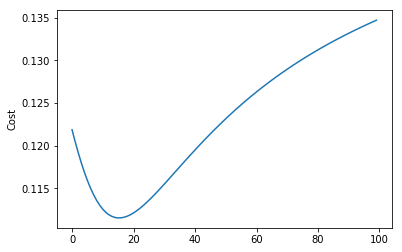

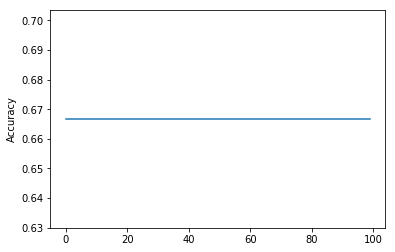

In [155]:
dataset = arff.loadarff('../data/weather.arff')
df = pd.DataFrame(dataset[0])

STR_COLUMNS = ['outlook', 'windy', 'play']

for column in STR_COLUMNS:
    df[column] = df[column].str.decode('utf-8')
    
df_encoded = pd.get_dummies(df, columns=['outlook', 'windy'])
df_encoded = pd.get_dummies(df_encoded, columns=['play'], drop_first=True)
df_encoded.temperature = df_encoded.temperature * 0.01
df_encoded.humidity = df_encoded.humidity * 0.01

X = df_encoded.iloc[:, :7].values
y = df_encoded.iloc[:, 7:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17779)

model = NeuralNetwork(input_nodes=7, hidden_nodes=[8], output_nodes=1, batch_size=14, learning_rate=0.1, momentum=0)
param, costs, accs = model.train(X_train, y_train, epochs=100)

print(param)
print()
print(costs)
print()
print(accs)

plt.plot(np.array(costs).mean(axis=1))
plt.ylabel('Cost')
plt.show()

plt.plot(accs)
plt.ylabel('Accuracy')
plt.show()

In [156]:
df = pd.read_csv('../data/train.csv')
df.fillna(df.median(), inplace=True)
X = df.drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Embarked'])
y = X['Survived']
X = X.drop(columns=['Survived'])
X = pd.get_dummies(X, columns=['Sex'])

nn = NeuralNetwork(input_nodes=6,
                   hidden_nodes=[32, 32],
                   output_nodes=1,
                   batch_size=64,
                   learning_rate=1e-2,
                   momentum=0)

params, cost, accuracy = nn.train(X.values, y.values, epochs=1000)

Epoch 0/1000, Loss=[1.80919387], Accuracy=5.3715572033898304
Epoch 1/1000, Loss=[1.79440672], Accuracy=5.3715572033898304
Epoch 2/1000, Loss=[1.77976781], Accuracy=5.3715572033898304
Epoch 3/1000, Loss=[1.7708033], Accuracy=5.3715572033898304
Epoch 4/1000, Loss=[1.76234559], Accuracy=5.3871822033898304
Epoch 5/1000, Loss=[1.75461737], Accuracy=5.7153072033898304
Epoch 6/1000, Loss=[1.74819736], Accuracy=7.4878177966101696
Epoch 7/1000, Loss=[1.74255882], Accuracy=8.23781779661017
Epoch 8/1000, Loss=[1.73800449], Accuracy=8.62844279661017
Epoch 9/1000, Loss=[1.7334828], Accuracy=8.62844279661017
Epoch 10/1000, Loss=[1.72994652], Accuracy=8.62844279661017
Epoch 11/1000, Loss=[1.72679797], Accuracy=8.62844279661017
Epoch 12/1000, Loss=[1.72389471], Accuracy=8.62844279661017
Epoch 13/1000, Loss=[1.72073688], Accuracy=8.62844279661017
Epoch 14/1000, Loss=[1.7184643], Accuracy=8.62844279661017
Epoch 15/1000, Loss=[1.71651446], Accuracy=8.62844279661017
Epoch 16/1000, Loss=[1.71420881], Accur

Epoch 139/1000, Loss=[1.68736965], Accuracy=8.62844279661017
Epoch 140/1000, Loss=[1.68732323], Accuracy=8.62844279661017
Epoch 141/1000, Loss=[1.68727652], Accuracy=8.62844279661017
Epoch 142/1000, Loss=[1.68722953], Accuracy=8.62844279661017
Epoch 143/1000, Loss=[1.68718225], Accuracy=8.62844279661017
Epoch 144/1000, Loss=[1.68713469], Accuracy=8.62844279661017
Epoch 145/1000, Loss=[1.68708687], Accuracy=8.62844279661017
Epoch 146/1000, Loss=[1.68703877], Accuracy=8.62844279661017
Epoch 147/1000, Loss=[1.68699042], Accuracy=8.62844279661017
Epoch 148/1000, Loss=[1.68694182], Accuracy=8.62844279661017
Epoch 149/1000, Loss=[1.68689298], Accuracy=8.62844279661017
Epoch 150/1000, Loss=[1.6868439], Accuracy=8.62844279661017
Epoch 151/1000, Loss=[1.6867946], Accuracy=8.62844279661017
Epoch 152/1000, Loss=[1.68674509], Accuracy=8.62844279661017
Epoch 153/1000, Loss=[1.68669538], Accuracy=8.62844279661017
Epoch 154/1000, Loss=[1.68664549], Accuracy=8.62844279661017
Epoch 155/1000, Loss=[1.68

Epoch 275/1000, Loss=[1.68237951], Accuracy=8.62844279661017
Epoch 276/1000, Loss=[1.68233715], Accuracy=8.62844279661017
Epoch 277/1000, Loss=[1.68229498], Accuracy=8.62844279661017
Epoch 278/1000, Loss=[1.68225299], Accuracy=8.62844279661017
Epoch 279/1000, Loss=[1.68221118], Accuracy=8.62844279661017
Epoch 280/1000, Loss=[1.68216956], Accuracy=8.62844279661017
Epoch 281/1000, Loss=[1.68212812], Accuracy=8.62844279661017
Epoch 282/1000, Loss=[1.68208687], Accuracy=8.62844279661017
Epoch 283/1000, Loss=[1.6820458], Accuracy=8.62844279661017
Epoch 284/1000, Loss=[1.68200492], Accuracy=8.62844279661017
Epoch 285/1000, Loss=[1.68196423], Accuracy=8.62844279661017
Epoch 286/1000, Loss=[1.68192373], Accuracy=8.62844279661017
Epoch 287/1000, Loss=[1.68188341], Accuracy=8.62844279661017
Epoch 288/1000, Loss=[1.68184328], Accuracy=8.62844279661017
Epoch 289/1000, Loss=[1.68180334], Accuracy=8.62844279661017
Epoch 290/1000, Loss=[1.68176359], Accuracy=8.62844279661017
Epoch 291/1000, Loss=[1.6

Epoch 411/1000, Loss=[1.67628234], Accuracy=8.62844279661017
Epoch 412/1000, Loss=[1.67627829], Accuracy=8.62844279661017
Epoch 413/1000, Loss=[1.67627427], Accuracy=8.62844279661017
Epoch 414/1000, Loss=[1.67627028], Accuracy=8.62844279661017
Epoch 415/1000, Loss=[1.67626632], Accuracy=8.62844279661017
Epoch 416/1000, Loss=[1.67626239], Accuracy=8.62844279661017
Epoch 417/1000, Loss=[1.67625849], Accuracy=8.62844279661017
Epoch 418/1000, Loss=[1.67625463], Accuracy=8.62844279661017
Epoch 419/1000, Loss=[1.67625079], Accuracy=8.62844279661017
Epoch 420/1000, Loss=[1.67624699], Accuracy=8.62844279661017
Epoch 421/1000, Loss=[1.67624322], Accuracy=8.62844279661017
Epoch 422/1000, Loss=[1.67623948], Accuracy=8.62844279661017
Epoch 423/1000, Loss=[1.67623578], Accuracy=8.62844279661017
Epoch 424/1000, Loss=[1.67623211], Accuracy=8.62844279661017
Epoch 425/1000, Loss=[1.67622847], Accuracy=8.62844279661017
Epoch 426/1000, Loss=[1.67622486], Accuracy=8.62844279661017
Epoch 427/1000, Loss=[1.

Epoch 547/1000, Loss=[1.67601543], Accuracy=8.62844279661017
Epoch 548/1000, Loss=[1.67601516], Accuracy=8.62844279661017
Epoch 549/1000, Loss=[1.67601492], Accuracy=8.62844279661017
Epoch 550/1000, Loss=[1.67601469], Accuracy=8.62844279661017
Epoch 551/1000, Loss=[1.67601449], Accuracy=8.62844279661017
Epoch 552/1000, Loss=[1.67601431], Accuracy=8.62844279661017
Epoch 553/1000, Loss=[1.67601415], Accuracy=8.62844279661017
Epoch 554/1000, Loss=[1.67601401], Accuracy=8.62844279661017
Epoch 555/1000, Loss=[1.67601389], Accuracy=8.62844279661017
Epoch 556/1000, Loss=[1.67601379], Accuracy=8.62844279661017
Epoch 557/1000, Loss=[1.67601371], Accuracy=8.62844279661017
Epoch 558/1000, Loss=[1.67601365], Accuracy=8.62844279661017
Epoch 559/1000, Loss=[1.67601361], Accuracy=8.62844279661017
Epoch 560/1000, Loss=[1.6760136], Accuracy=8.62844279661017
Epoch 561/1000, Loss=[1.6760136], Accuracy=8.62844279661017
Epoch 562/1000, Loss=[1.67601362], Accuracy=8.62844279661017
Epoch 563/1000, Loss=[1.67

Epoch 683/1000, Loss=[1.67614385], Accuracy=8.62844279661017
Epoch 684/1000, Loss=[1.67614583], Accuracy=8.62844279661017
Epoch 685/1000, Loss=[1.67614783], Accuracy=8.62844279661017
Epoch 686/1000, Loss=[1.67614984], Accuracy=8.62844279661017
Epoch 687/1000, Loss=[1.67615186], Accuracy=8.62844279661017
Epoch 688/1000, Loss=[1.67615389], Accuracy=8.62844279661017
Epoch 689/1000, Loss=[1.67615594], Accuracy=8.62844279661017
Epoch 690/1000, Loss=[1.676158], Accuracy=8.62844279661017
Epoch 691/1000, Loss=[1.67616007], Accuracy=8.62844279661017
Epoch 692/1000, Loss=[1.67616216], Accuracy=8.62844279661017
Epoch 693/1000, Loss=[1.67616425], Accuracy=8.62844279661017
Epoch 694/1000, Loss=[1.67616636], Accuracy=8.62844279661017
Epoch 695/1000, Loss=[1.67616848], Accuracy=8.62844279661017
Epoch 696/1000, Loss=[1.67617062], Accuracy=8.62844279661017
Epoch 697/1000, Loss=[1.67617276], Accuracy=8.62844279661017
Epoch 698/1000, Loss=[1.67617492], Accuracy=8.62844279661017
Epoch 699/1000, Loss=[1.67

Epoch 818/1000, Loss=[1.67651174], Accuracy=8.62844279661017
Epoch 819/1000, Loss=[1.67651512], Accuracy=8.62844279661017
Epoch 820/1000, Loss=[1.6765185], Accuracy=8.62844279661017
Epoch 821/1000, Loss=[1.67652189], Accuracy=8.62844279661017
Epoch 822/1000, Loss=[1.67652529], Accuracy=8.62844279661017
Epoch 823/1000, Loss=[1.6765287], Accuracy=8.62844279661017
Epoch 824/1000, Loss=[1.67653211], Accuracy=8.62844279661017
Epoch 825/1000, Loss=[1.67653554], Accuracy=8.62844279661017
Epoch 826/1000, Loss=[1.67653897], Accuracy=8.62844279661017
Epoch 827/1000, Loss=[1.67654241], Accuracy=8.62844279661017
Epoch 828/1000, Loss=[1.67654586], Accuracy=8.62844279661017
Epoch 829/1000, Loss=[1.67654931], Accuracy=8.62844279661017
Epoch 830/1000, Loss=[1.67655277], Accuracy=8.62844279661017
Epoch 831/1000, Loss=[1.67655625], Accuracy=8.62844279661017
Epoch 832/1000, Loss=[1.67655973], Accuracy=8.62844279661017
Epoch 833/1000, Loss=[1.67656321], Accuracy=8.62844279661017
Epoch 834/1000, Loss=[1.67

Epoch 954/1000, Loss=[1.67703636], Accuracy=8.62844279661017
Epoch 955/1000, Loss=[1.67704064], Accuracy=8.62844279661017
Epoch 956/1000, Loss=[1.67704492], Accuracy=8.62844279661017
Epoch 957/1000, Loss=[1.67704921], Accuracy=8.62844279661017
Epoch 958/1000, Loss=[1.6770535], Accuracy=8.62844279661017
Epoch 959/1000, Loss=[1.6770578], Accuracy=8.62844279661017
Epoch 960/1000, Loss=[1.67706211], Accuracy=8.62844279661017
Epoch 961/1000, Loss=[1.67706641], Accuracy=8.62844279661017
Epoch 962/1000, Loss=[1.67707073], Accuracy=8.62844279661017
Epoch 963/1000, Loss=[1.67707504], Accuracy=8.62844279661017
Epoch 964/1000, Loss=[1.67707937], Accuracy=8.62844279661017
Epoch 965/1000, Loss=[1.6770837], Accuracy=8.62844279661017
Epoch 966/1000, Loss=[1.67708803], Accuracy=8.62844279661017
Epoch 967/1000, Loss=[1.67709237], Accuracy=8.62844279661017
Epoch 968/1000, Loss=[1.67709671], Accuracy=8.62844279661017
Epoch 969/1000, Loss=[1.67710106], Accuracy=8.62844279661017
Epoch 970/1000, Loss=[1.677